In [221]:
import numpy as np
import pandas as pd

votes

In [222]:
file_name = 'votes.csv'
data = pd.read_csv(file_name)

In [223]:
data = data[["vote_id", "state_code", "vote"]]
data.rename(columns={"vote_id": "rcid"}, inplace=True)

In [224]:
lack_state_code = [260, 265, 315, 511, 678, 680, 713, 255, 679, 341]
all_rcids = set(data["rcid"].unique())

new_rcids = []
new_state_codes = []
new_votes = []
for code in lack_state_code:
    lack_rcids = list(all_rcids - set(data["rcid"][data["state_code"]==code].unique()))
    new_rcids += lack_rcids
    new_state_codes += [code] * len(lack_rcids)
    new_votes += [8] * len(lack_rcids)

lack_data = pd.DataFrame({"rcid": new_rcids, "state_code": new_state_codes, "vote": new_votes})

In [225]:
data = pd.concat([data, lack_data], axis=0)
data = data.reset_index()

In [226]:
data

,index,rcid,state_code,vote
0,0,3,2,1
1,1,3,20,3
2,2,3,31,9
3,3,3,40,1
4,4,3,41,1
...,...,...,...,...
1085795,19182,9052,341,8
1085796,19183,9053,341,8
1085797,19184,9054,341,8
1085798,19185,9055,341,8


issue

In [227]:
issue = pd.read_csv("issues.csv")

In [228]:
issue.shape

(5745, 3)

In [229]:
issue.head()
# rcid num = 9004

,rcid,short_name,issue
0,77,me,Palestinian conflict
1,9001,me,Palestinian conflict
2,9002,me,Palestinian conflict
3,9003,me,Palestinian conflict
4,9004,me,Palestinian conflict


In [230]:
set(issue.issue)

{'Arms control and disarmament',
 'Colonialism',
 'Economic development',
 'Human rights',
 'Nuclear weapons and nuclear material',
 'Palestinian conflict'}

imputation

In [231]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(max_features=2)

In [232]:
model.fit(data[["rcid", "state_code"]].loc[data["vote"].isin([1,2,3])], data["vote"].loc[data["vote"].isin([1,2,3])])

RandomForestClassifier(max_features=2)

In [233]:
model.score(data[["rcid", "state_code"]].loc[data["vote"].isin([1,2,3])], data["vote"].loc[data["vote"].isin([1,2,3])])

0.9999323193875175

In [234]:
out = model.predict(data[["rcid", "state_code"]].loc[data["vote"].isin([8, 9])])

In [235]:
np.unique(out)

array([1, 2, 3], dtype=int64)

In [236]:
data["vote"][data["vote"].isin([8, 9])] = out

In [237]:
data["vote"].unique()

array([1, 3, 2], dtype=int64)

merge

In [238]:
result = pd.merge(data, issue, on="rcid")

In [239]:
result.head()

,index,rcid,state_code,vote,short_name,issue
0,591,6,2,3,hr,Human rights
1,592,6,20,3,hr,Human rights
2,593,6,31,1,hr,Human rights
3,594,6,40,1,hr,Human rights
4,595,6,41,1,hr,Human rights


issue별 clustering

In [288]:
me = result[result["short_name"]=="me"]
hr = result[result["short_name"]=="hr"]
ec = result[result["short_name"]=="ec"]
di = result[result["short_name"]=="di"]
nu = result[result["short_name"]=="nu"]
co = result[result["short_name"]=="co"]

In [241]:
me

,index,rcid,state_code,vote,short_name,issue
7400,14578,77,2,1,me,Palestinian conflict
7402,14579,77,20,1,me,Palestinian conflict
7404,14580,77,31,3,me,Palestinian conflict
7406,14581,77,40,3,me,Palestinian conflict
7408,14582,77,41,1,me,Palestinian conflict
...,...,...,...,...,...,...
1019995,3323,5463,315,1,me,Palestinian conflict
1019996,4048,5463,511,1,me,Palestinian conflict
1019997,5839,5463,678,1,me,Palestinian conflict
1019998,6564,5463,680,1,me,Palestinian conflict


In [242]:
class SphericalKMeans():
    def __init__(self, n_clusters, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.clusters = None
        self.label = None

    def cosine_similarity(self, X, Y):
        return np.dot(X,Y) / (np.linalg.norm(X, ord=2)*np.linalg.norm(Y, ord=2))
    
    def fit(self, data):
        clusters = np.random.uniform(size=(self.n_clusters, (len(data[0]))))
        for _ in range(self.max_iter):
            sim = np.empty((len(data), self.n_clusters))
            for i, e in enumerate(data):
                for j, cluster in enumerate(clusters):
                    sim[i,j] = self.cosine_similarity(e, cluster)
            label = np.argmax(sim, axis=1)
            for k in range(self.n_clusters):
                clusters[k] = np.mean(data[label==k], axis=0)
        self.clusters = clusters
        self.label = label

In [243]:
model = SphericalKMeans(n_clusters=2, max_iter=100)

In [244]:
result[result.state_code==2]

,index,rcid,state_code,vote,short_name,issue
0,591,6,2,3,hr,Human rights
200,985,8,2,3,ec,Economic development
400,1576,11,2,1,co,Colonialism
401,1576,11,2,1,ec,Economic development
800,2955,18,2,3,ec,Economic development
...,...,...,...,...,...,...
1019400,1065262,5460,2,3,ec,Economic development
1019600,1065648,5462,2,1,ec,Economic development
1019800,1065841,5463,2,3,me,Palestinian conflict
1020000,1066034,5464,2,1,co,Colonialism


In [245]:
# X: us, Y: all countries
X = result[result.state_code==2]
Y = result[result.state_code !=2]

In [246]:
def preprocessing(df):
    states_code = df["state_code"].unique()
    rcids = df["rcid"].unique()
    new_df = pd.DataFrame(index=states_code, columns=rcids)
    for code in states_code:
        new_df.loc[code] = df["vote"][df["state_code"]==code].values
    return new_df

In [247]:
new_me = preprocessing(me)

model = SphericalKMeans(n_clusters=2, max_iter=100)
model.fit(new_me.values)
new_me["label"] = model.label

In [248]:
new_hr = preprocessing(hr)

model = SphericalKMeans(n_clusters=2, max_iter=100)
model.fit(new_hr.values)
new_hr["label"] = model.label

In [249]:
new_ec = preprocessing(ec)

model = SphericalKMeans(n_clusters=2, max_iter=100)
model.fit(new_ec.values)
new_ec["label"] = model.label

In [250]:
new_di = preprocessing(di)

model = SphericalKMeans(n_clusters=2, max_iter=100)
model.fit(new_di.values)
new_di["label"] = model.label

In [251]:
new_nu = preprocessing(nu)

model = SphericalKMeans(n_clusters=2, max_iter=100)
model.fit(new_nu.values)
new_nu["label"] = model.label

In [289]:
new_co = preprocessing(co)

model = SphericalKMeans(n_clusters=2, max_iter=100)
model.fit(new_co.values)
new_co["label"] = model.label

cos similarity with usa

In [253]:
X = new_co.loc[2].values[:-1].astype(float)
Y = new_co.iloc[:,:-1].values.astype(float)
# np.dot(X, Y.T) / (np.linalg.norm(X, ord=2)*np.linalg.norm(Y.T, axis=0, ord=2))

In [290]:
def cos_sim(df):
    X = df.loc[2].values[:-1].astype(float)
    Y = df.iloc[:,:-1].values.astype(float)
    out = np.dot(X, Y.T) / (np.linalg.norm(X, ord=2)*np.linalg.norm(Y.T, axis=0, ord=2))
    return out


for new in [new_co, new_di, new_ec, new_hr, new_nu, new_me]:
    out = cos_sim(new)
    new["similarity2usa"] = out

In [255]:
aa = pd.read_csv(file_name)[["state_name", "state_code"]]
state_dict = {}
for i in range(len(aa)):
    if aa.iloc[i,1] not in state_dict:
        state_dict[aa.iloc[i,1]] = aa.iloc[i,0]

In [256]:
aaa = new_me.sort_values(by=["similarity2usa"], ascending=[True])
aaa
for a in aaa.index:
    print(state_dict[a], aaa.loc[a]['similarity2usa'])
# aaa.loc[371]["similarity2usa"]

Syria 0.8645313269505299
Albania 0.8784044547340285
Iraq 0.8800099248407103
Montenegro 0.880233757205823
Turkmenistan 0.8823075565345867
Afghanistan 0.8838653338270084
German Democratic Republic 0.8844328436887825
Armenia 0.8847769572797859
Poland 0.8862019727588685
Belarus 0.8868647552089769
Cuba 0.887080211696408
Lithuania 0.8872094485506103
Latvia 0.8873823023983185
Russia 0.8876893543192309
Estonia 0.8877009246458529
Georgia 0.8878229456468969
Czech Republic 0.8879350926534426
Czechoslovakia 0.8879350926534426
Hungary 0.8880231361375366
Slovakia 0.8881618129399049
Ukraine 0.8892358055757676
Bulgaria 0.8908770800907306
Yemen People's Republic 0.8921911563053141
Yemen Arab Republic 0.8922447708521
South Africa 0.8923554227515732
Yemen 0.892998141715082
Nicaragua 0.8935792037062028
Costa Rica 0.8941308850950566
Uzbekistan 0.8969883375473253
Mongolia 0.8985233582447492
Azerbaijan 0.8997760904852995
Guatemala 0.9002909342219378
Namibia 0.9006403899855119
Nauru 0.9007275770038132
Taiwan 

In [257]:
aaa = new_hr.sort_values(by=["similarity2usa"], ascending=[True])
aaa
for a in aaa.index:
    print(state_dict[a], aaa.loc[a]['similarity2usa'])

Cuba 0.7455623973204236
Syria 0.7477813738314183
Sudan 0.7611137847587108
Belarus 0.7641026331321005
Libya 0.7647629784598584
China 0.7665348139628042
Iran 0.7706997631267922
Zimbabwe 0.7745809016362663
North Korea 0.7747678436892828
Vietnam 0.7758464767196128
India 0.776532077087772
Myanmar 0.7811528674033217
Russia 0.7844321409409565
Indonesia 0.7848204226186557
Algeria 0.7857951944917764
Pakistan 0.7881320124285033
Oman 0.7930122158890871
Qatar 0.7938528162211752
Afghanistan 0.7964156790382424
Bangladesh 0.7967589518203361
Yemen People's Republic 0.7980414311023601
Egypt 0.7987276966285448
Namibia 0.800140496458082
Turkmenistan 0.802482278974237
Sri Lanka 0.8055727563390476
Malaysia 0.8069384801674903
Armenia 0.8074551993547923
Laos 0.8076983603165142
Yemen Arab Republic 0.8083357635341212
Kuwait 0.8089585815924641
Nigeria 0.8094551281898066
Yemen 0.8107156652842352
Niger 0.811043097651779
Bahrain 0.8113120268969324
Lebanon 0.8115691289831042
Brunei 0.812207765257774
Saudi Arabia 0.

In [258]:
# aa = np.dot(X, Y.T) / (np.linalg.norm(X, ord=2)*np.linalg.norm(Y.T, axis=0, ord=2))
# aa.shape

# aa = pd.read_csv(file_name)[["state_name", "state_code"]]
# state_dict = {}
# for i in range(len(aa)):
#     if aa.iloc[i,1] not in state_dict:
#         state_dict[aa.iloc[i,1]] = aa.iloc[i,0]

# for code, label_co in zip(state_dict, new_co.similarity2usa):
#     print("{} : {}".format(state_dict[code], label_co))


# min(sorted(new_co.similarity2usa))

In [259]:
state_dict

{2: 'United States of America',
 20: 'Canada',
 31: 'Bahamas',
 40: 'Cuba',
 41: 'Haiti',
 42: 'Dominican Republic',
 51: 'Jamaica',
 52: 'Trinidad and Tobago',
 53: 'Barbados',
 54: 'Dominica',
 55: 'Grenada',
 56: 'St. Lucia',
 57: 'St. Vincent and the Grenadines',
 58: 'Antigua & Barbuda',
 60: 'St. Kitts and Nevis',
 70: 'Mexico',
 80: 'Belize',
 90: 'Guatemala',
 91: 'Honduras',
 92: 'El Salvador',
 93: 'Nicaragua',
 94: 'Costa Rica',
 95: 'Panama',
 100: 'Colombia',
 101: 'Venezuela',
 110: 'Guyana',
 115: 'Suriname',
 130: 'Ecuador',
 135: 'Peru',
 140: 'Brazil',
 145: 'Bolivia',
 150: 'Paraguay',
 155: 'Chile',
 160: 'Argentina',
 165: 'Uruguay',
 200: 'United Kingdom',
 205: 'Ireland',
 210: 'Netherlands',
 211: 'Belgium',
 212: 'Luxembourg',
 220: 'France',
 221: 'Monaco',
 223: 'Liechtenstein',
 225: 'Switzerland',
 230: 'Spain',
 232: 'Andorra',
 235: 'Portugal',
 260: 'German Federal Republic',
 265: 'German Democratic Republic',
 290: 'Poland',
 305: 'Austria',
 310: 'Hun

In [260]:
# min(sorted(new_co.similarity2usa))
aaa = new_co.sort_values(by=["similarity2usa"], ascending=[True])
aaa
for a in aaa.index:
    print(state_dict[a], aaa.loc[a]['similarity2usa'])
# aaa.loc[371]["similarity2usa"]

Armenia 0.8253457670523331
Belarus 0.8278250735758445
Ukraine 0.82859812108821
Albania 0.830151287756114
Russia 0.8308031803383181
Montenegro 0.8314308445127255
Lithuania 0.8325054854043331
Latvia 0.8329623724992846
Estonia 0.8330325295048643
Georgia 0.8333264179145933
Namibia 0.8336228991108415
Poland 0.8340849084488147
German Democratic Republic 0.8345484041364355
Moldova 0.8385652371689782
Romania 0.8385663815812346
Czechoslovakia 0.8409492403813807
Czech Republic 0.8409492403813807
Hungary 0.8420006871359521
Slovakia 0.8424185340361912
Malta 0.8424548862257313
Bosnia and Herzegovina 0.8447841702844066
Zimbabwe 0.8456818559153074
Yugoslavia 0.8462584494715082
Croatia 0.8477614509920292
Zambia 0.8482242456706172
Seychelles 0.8482326682553621
Macedonia 0.848351078917443
Lesotho 0.8492693565338991
Madagascar 0.8517763503956344
Mauritania 0.8525360883396673
South Africa 0.8527034389118516
Congo 0.8533050747814703
Cuba 0.8537754363799317
Syria 0.8541598618494843
Bulgaria 0.85426337606251

In [261]:
aaa = new_ec.sort_values(by=["similarity2usa"], ascending=[True])
aaa
for a in aaa.index:
    print(state_dict[a], aaa.loc[a]['similarity2usa'])

Armenia 0.7617923304123305
Belarus 0.7624197751339602
Russia 0.7653603233330073
Mongolia 0.7714873990703365
Cuba 0.7724061648078417
North Korea 0.7785098413269151
Ukraine 0.7795135395395948
Taiwan 0.7803011768006516
Montenegro 0.7835067905421078
Albania 0.783754388220448
Lithuania 0.7851458952331378
Georgia 0.7855680943175406
Estonia 0.786032927716012
Hungary 0.7868057961667178
Slovakia 0.7871104236676523
German Democratic Republic 0.7883984610324402
Czech Republic 0.7888847866974641
Czechoslovakia 0.7888847866974641
Latvia 0.7889056788778458
Poland 0.7934853663459138
Bulgaria 0.7946761776139806
Syria 0.7980372392816285
Afghanistan 0.8138215709486298
Yemen People's Republic 0.8142252712787585
Romania 0.8163273963826434
Moldova 0.8166626024069672
Iraq 0.8208345202596915
Yemen 0.8270013721294754
Yemen Arab Republic 0.8272172056339863
Namibia 0.8325027816256579
China 0.8341465292221308
Malta 0.8357143646857906
South Africa 0.837101109205408
Bahamas 0.8372980846350688
Saudi Arabia 0.837966

In [262]:
aaa = new_nu.sort_values(by=["similarity2usa"], ascending=[True])
aaa
for a in aaa.index:
    print(state_dict[a], aaa.loc[a]['similarity2usa'])

Montenegro 0.8287561898952344
Albania 0.8321738326667373
Cuba 0.8332257974839424
North Korea 0.8346463256906802
India 0.835437803244103
Bhutan 0.8389909507200904
Mauritius 0.8496491494660695
Mongolia 0.8524755486612846
Ukraine 0.8606123034207924
China 0.8633285648515532
Taiwan 0.8640310239857856
Lithuania 0.8648473716176829
Bulgaria 0.8666572961554825
Slovakia 0.8672188777500327
Estonia 0.8675292562822068
Poland 0.8682079870633569
Georgia 0.868858908972987
Czechoslovakia 0.8689804355956826
Czech Republic 0.8689804355956826
Latvia 0.8690402376440198
Hungary 0.8691846853189393
German Democratic Republic 0.8691879057846473
Belarus 0.8697598987112793
Algeria 0.8713839127435326
Armenia 0.87309867419968
Russia 0.8735369615781082
Nauru 0.875324101689012
Brazil 0.8762338026721126
Cyprus 0.8785797471060923
Namibia 0.8796618458648409
Myanmar 0.8798984981675915
Romania 0.8811774958956524
Bosnia and Herzegovina 0.8813026063229346
Malta 0.8815432213028792
Pakistan 0.8817913260235717
South Africa 0.

 0.8860760322560253
Moldova 0.8860787335443323
Zambia 0.8880112374168259
Yugoslavia 0.8881775681762025
Bahamas 0.8892554797907916
Malawi 0.8903328779287905
Vietnam 0.8911881683412894
Afghanistan 0.8923897714304401
Congo 0.8934359751105073
Laos 0.8935263611297112
Nicaragua 0.89394531396996
Zanzibar 0.8949695425859007
Tanzania 0.8949695425859007
Angola 0.8954523477831524
East Timor 0.8955170688656002
Marshall Islands 0.8958669838231462
Indonesia 0.8962083112972744
Seychelles 0.8970127236998672
Mozambique 0.8970417259514392
Yemen People's Republic 0.8987842063165825
Palau 0.8990456917150464
Central African Republic 0.900226788395538
Federated States of Micronesia 0.901778599616046
Guyana 0.9020442887954896
Lesotho 0.9022645465701912
Austria 0.902468920610597
Sweden 0.9026149058769903
Finland 0.902984268669073
Ethiopia 0.9030562410587939
Uganda 0.9034333087762997
Eritrea 0.9036461743172252
Mauritania 0.9037180940199687
Tuvalu 0.9040550817798111
Kiribati 0.9043752644327514
Grenada 0.9044730

In [263]:
aaa = new_di.sort_values(by=["similarity2usa"], ascending=[True])
aaa
for a in aaa.index:
    print(state_dict[a], aaa.loc[a]['similarity2usa'])

Cuba 0.8151800775855982
India 0.8269542147638251
North Korea 0.8281008054021145
Montenegro 0.8371954568941059
Albania 0.8401490089214653
Mongolia 0.8428759612973173
Taiwan 0.8494522167370504
Syria 0.8508467404426321
Russia 0.8518051669321972
Belarus 0.852050790179947
Ukraine 0.8538083327733318
China 0.8561643321912926
Lithuania 0.8584273507434335
Slovakia 0.8594095741348219
Estonia 0.8596009506429148
Georgia 0.8600341352593442
Poland 0.8604867698128446
Czechoslovakia 0.8608655544802956
Czech Republic 0.8608655544802956
Armenia 0.8610310671695914
German Democratic Republic 0.861061476881227
Afghanistan 0.8612332009448176
Latvia 0.8613420723741227
Hungary 0.8613917420292523
Vietnam 0.8618421859829002
Bulgaria 0.8621977613112569
Nauru 0.8632502321517429
Algeria 0.8641841536612536
Yemen People's Republic 0.8656782009912932
Iran 0.8681460485283052
Laos 0.869144678006433
Egypt 0.8718962480298003
Pakistan 0.8739885689213712
Brazil 0.87608208437309
Bhutan 0.8778532307099608
Myanmar 0.878681828

clustering - model.label

In [264]:
aa = pd.read_csv(file_name)[["state_name", "state_code"]]
state_dict = {}
for i in range(len(aa)):
    if aa.iloc[i,1] not in state_dict:
        state_dict[aa.iloc[i,1]] = aa.iloc[i,0]

In [265]:
state_dict

{2: 'United States of America',
 20: 'Canada',
 31: 'Bahamas',
 40: 'Cuba',
 41: 'Haiti',
 42: 'Dominican Republic',
 51: 'Jamaica',
 52: 'Trinidad and Tobago',
 53: 'Barbados',
 54: 'Dominica',
 55: 'Grenada',
 56: 'St. Lucia',
 57: 'St. Vincent and the Grenadines',
 58: 'Antigua & Barbuda',
 60: 'St. Kitts and Nevis',
 70: 'Mexico',
 80: 'Belize',
 90: 'Guatemala',
 91: 'Honduras',
 92: 'El Salvador',
 93: 'Nicaragua',
 94: 'Costa Rica',
 95: 'Panama',
 100: 'Colombia',
 101: 'Venezuela',
 110: 'Guyana',
 115: 'Suriname',
 130: 'Ecuador',
 135: 'Peru',
 140: 'Brazil',
 145: 'Bolivia',
 150: 'Paraguay',
 155: 'Chile',
 160: 'Argentina',
 165: 'Uruguay',
 200: 'United Kingdom',
 205: 'Ireland',
 210: 'Netherlands',
 211: 'Belgium',
 212: 'Luxembourg',
 220: 'France',
 221: 'Monaco',
 223: 'Liechtenstein',
 225: 'Switzerland',
 230: 'Spain',
 232: 'Andorra',
 235: 'Portugal',
 260: 'German Federal Republic',
 265: 'German Democratic Republic',
 290: 'Poland',
 305: 'Austria',
 310: 'Hun

In [266]:
for code, label_me, label_hr, label_di, label_ec, label_nu, label_co in zip(new_hr.index, new_me.label, new_hr.label, new_di.label, new_ec.label, new_nu.label, new_co.label):
    print("{} : {} {} {} {} {} {}".format(state_dict[code], label_me, label_hr, label_di, label_ec, label_nu, label_co))

United States of America : 0 1 1 1 1 1
Canada : 0 1 1 1 1 1
Bahamas : 1 0 0 1 1 0
Cuba : 1 0 0 0 1 0
Haiti : 0 0 0 1 1 0
Dominican Republic : 0 0 0 1 1 1
Jamaica : 0 0 0 1 1 1
Trinidad and Tobago : 0 0 0 1 1 1
Barbados : 0 0 0 1 1 1
Dominica : 0 0 0 1 1 1
Grenada : 0 0 0 1 1 1
St. Lucia : 0 0 0 1 1 1
St. Vincent and the Grenadines : 0 0 0 1 1 0
Antigua & Barbuda : 0 0 0 1 1 0
St. Kitts and Nevis : 0 0 0 1 1 0
Mexico : 0 0 0 1 1 0
Belize : 0 0 0 1 1 0
Guatemala : 0 0 0 1 1 0
Honduras : 0 0 0 1 1 1
El Salvador : 0 0 0 1 1 1
Nicaragua : 0 0 0 1 1 1
Costa Rica : 0 0 0 1 1 1
Panama : 0 0 0 1 1 1
Colombia : 0 0 0 1 1 1
Venezuela : 0 0 0 1 1 0
Guyana : 1 0 0 1 1 0
Suriname : 0 0 0 1 1 0
Ecuador : 0 0 0 1 1 1
Peru : 0 0 0 1 1 1
Brazil : 0 0 0 1 1 1
Bolivia : 0 0 0 1 1 1
Paraguay : 0 0 0 1 1 1
Chile : 0 0 0 1 1 1
Argentina : 0 0 0 1 1 1
Uruguay : 0 0 0 1 1 1
United Kingdom : 0 1 1 1 1 1
Ireland : 0 1 1 1 1 1
Netherlands : 0 1 1 1 1 1
Belgium : 0 1 1 1 1 1
Luxembourg : 0 1 1 1 1 1
France : 0 1 1

fdi

In [267]:
import numpy as np
import pandas as pd

fdi_data = pd.read_csv("fdi_1994_2017.csv")
fdi = fdi_data.iloc[:,1:]

In [268]:
fdi.rename(columns={"...2": "fdi_val"}, inplace=True)

In [269]:
fdi[fdi["fdi_val"].isin(['(*)', '(D)'])] = 0

In [270]:
fdi['fdi_val'] = fdi["fdi_val"].astype(float)
fdi['year'] = fdi['year'].astype(object)

In [271]:
fdi.head()

,year,country,fdi_val
0,1994,"All countries, all industries",73252.0
1,1994,Canada,6047.0
2,1994,Europe,34380.0
3,1994,Austria,744.0
4,1994,Belgium,2004.0


In [272]:
state_code = fdi["country"].unique() # regressin or mean
# vecotor 만들어주기
fdi_value = ["fdi_value"]
new_fdi = pd.DataFrame(index=state_code,columns=fdi_value)

new_fdi.head()
new_fdi.loc["Canada"]

country_code = set(fdi.country.values)
exist_state = [con for con in country_code if con in state_dict.values()]
new_fdi = pd.DataFrame(index=exist_state, columns=fdi_value)

In [273]:
state_code # county in fdi data
new_fdi.head()

,fdi_value
Luxembourg,NaN
Hungary,NaN
Panama,NaN
Nigeria,NaN
Malaysia,NaN


In [274]:
for state in exist_state:
    new_fdi.loc[state] = fdi[fdi["country"]==state]["fdi_val"].mean()

In [275]:
new_fdi.head()

,fdi_value
Luxembourg,16557.541667
Hungary,79.052632
Panama,506.041667
Nigeria,354.75
Malaysia,1008.565217


In [276]:
# cnt = 0
# for state in state_code:
    # new_fdi["country" == state]['fdi_val'] = fdi[fdi["country"]==state]["fdi_val"].mean()
    # new_fdi.loc["country" == state][cnt] = fdi[fdi["country"]==state]["fdi_val"].mean
    # new_fdi.loc["country" == state][cnt]
    # print(fdi[fdi["country"]==state]["fdi_val"].mean())
    # print(cnt, state)
    # cnt+=1
    # print(new_fdi.loc[state][i])
# new_fdi

In [277]:
for state in state_code:
    print(state)

All countries, all industries
Canada
Europe
Austria
Belgium
Denmark
Finland
France
Germany
Greece
Ireland
Italy
Luxembourg
Netherlands
Norway
Portugal
Spain
Sweden
Switzerland
Turkey
United Kingdom
Other
Western Hemisphere
South America
Argentina
Brazil
Chile
Colombia
Ecuador
Peru
Venezuela
Central America
Costa Rica
Guatemala
Honduras
Mexico
Panama
Other Western Hemisphere
Bahamas
Barbados
Bermuda
Dominican Republic
Jamaica
Netherlands Antilles
Trinidad and Tobago
United Kingdom Islands, Caribbean3
Africa
Egypt
Nigeria
South Africa
Middle East
Israel
Saudi Arabia
United Arab Emirates
Asia and Pacific
Australia
China
Hong Kong
India
Indonesia
Japan
Malaysia
New Zealand
Philippines
Singapore
South Korea
Taiwan
Thailand
International1
Eastern Europe2
European Union4
OPEC5
Petroleum
Manufacturing
Food and kindred products
Chemicals and allied products
Primary and fabricated metals
Industrial machinery and equipment
Electronic and other electric equipment
Transportation equipment
Other man

gpt <br>
: for trade data,

In [ ]:
! pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, set_seed

ckp = 't5_small'
tokenizer = AutoTokenizer.from_pretrained(ckp)
model = AutoModelForSeq2SeqLM.from_pretrained(ckp)

for state in list(trade.country):
    prompt = f"한국어를 영어로 번역해줘. {state}"
    input = tokenizer(prompt, return_tensors='pt')

    outputs = model.generate(**inputs, num_beam=5, do_sample=True)
    tokenizer.decode(outputs[0], skip_special_tokens=True)

In [418]:
# 의미 있는 숫자로 바꿔서 correlation not categorical data
# from transformers import AutoModelForMachineTranslation
# input_ids = "hello world"
# model.generate("")
# country_code = set(fdi.country.values)
# country_code

trade

In [604]:
file_name = 'trade_with_usa.xlsx'
data = pd.read_excel(file_name)
trade = pd.DataFrame(data)

,country,year,수입_점유율,수출_점유율,수출입_비율
0,캐나다,2016,52.18,72.18,62.18
1,멕시코,2016,46.48,73.68,60.08
2,중국,2016,8.51,21.42,14.96
3,일본,2016,11.41,18.65,15.03
4,독일,2016,6.21,9.39,7.80
...,...,...,...,...,...
1470,바티칸시,2022,0.02,44.29,22.16
1471,노퍽섬,2022,0.19,8.84,4.52
1472,"월리스,후투나",2022,0.05,6.27,3.16
1473,허드맥도날드제도,2022,0.24,74.34,37.29


In [425]:
set(list(trade.country))
country_dict = {a:b for a, b in zip(trade.country, country)}
country_dict.values()

dict_values(['Dominican Republic', 'Lithuania', 'Fiji', 'Bolivia', 'Greenland', 'South Korea', 'Vatican City', 'Sint Maarten (Dutch part)', 'Philippines', 'Ethiopia', 'Barbados', 'Saint Kitts and Nevis', 'Romania', 'Polynesia (Fr.)', 'Belgium', 'Vanuatu', 'Macau', 'Egypt', 'China', 'Brunei', 'Uganda', 'Marshall Islands', 'Lebanon', 'Zambia', 'Poland', 'Azerbaijan', 'Pitcairn Island', 'Micronesia', 'Mali', 'Virgin Islands, British', 'Mauritania', 'Nepal', 'Somalia', 'Serbia', 'Jordan', 'Nauru', 'Belarus', 'Portugal', 'Cuba', 'Grenada', 'Mexico', 'Central African Republic', 'Norway', 'Iran', 'Cape Verde', 'Zimbabwe', 'Austria', 'Sudan', 'Bahrain', 'Turks and Caicos Islands', 'Guinea-Bissau', 'Trinidad and Tobago', 'Solomon Islands', 'Afghanistan', 'United Kingdom', 'Italy', 'Greece', 'Ireland', 'Israel', 'Samoa (Western Samoa)', 'Taiwan', 'Guyana', 'Madagascar', 'Equatorial Guinea', 'Iraq', 'Vietnam', 'Namibia', 'Christmas Island', 'Antigua and Barbuda', 'Saudi Arabia', 'Germany', 'San M

In [436]:
len(set(country_dict.values()) & set(state_dict.values()))

122

correlation

In [313]:
# np.corrcoef()
# 이슈별로 나눈 이유
# new_fdi
# new_co[["similarity2usa"]]
# np.corrcoef(new_fdi, new_co[["similarity2usa"]])
# bbb = pd.DataFrame(new_co["similarity2usa"].values, index=state_dict.values()) # *
# np.corrcoef(bbb, new_fdi)
# new_fdi.drop(new_fdi[[new_fdi[].isin]], axis=1, inplace=True)

In [ ]:
bbb= pd.DataFrame(new_co["similarity2usa"].values, index=)
# bbb["state"] = list(state_dict.values())
bbb["state"] = [con for con in country_code if con in state_dict.values()]
bbb["similarity2usa"] = new_co["similarity2usa"].values
bbb["fdi_val"] = fdi.values

In [ ]:
# [state.isin([con for con in country_code if con in state_dict.values()])]

[(new_fdi.loc[con].values, con) for con in country_code if con in state_dict.values()]

In [389]:
new_co.reset_index(drop=True, inplace=True)
new_co.index = state_dict.values()

bbb = pd.DataFrame(index=[con for con in country_code if con in state_dict.values()])
sim_val = []

for state in [con for con in country_code if con in state_dict.values()]:
    sim_val.append(new_co.loc[state].similarity2usa)

bbb["similarity2usa"] = sim_val
bbb["fdi_val"] = list(new_fdi.fdi_value)

In [437]:
new_co.loc["Canada"].similarity2usa
new_co
bbb.head()

,similarity2usa,fdi_val
Luxembourg,0.936729,16557.541667
Hungary,0.861271,79.052632
Panama,0.871060,506.041667
Nigeria,0.809386,354.750000
Malaysia,0.806870,1008.565217


In [ ]:
list(new_fdi.fdi_value)

In [392]:
np.corrcoef(list(bbb.similarity2usa), list(bbb.fdi_val))

array([[1.        , 0.45963639],
       [0.45963639, 1.        ]])

In [394]:
# softmax, normalization, standardation
new_di.reset_index(drop=True, inplace=True)
new_di.index = state_dict.values()

bbb = pd.DataFrame(index=[con for con in country_code if con in state_dict.values()])
sim_val = []

for state in [con for con in country_code if con in state_dict.values()]:
    sim_val.append(new_di.loc[state].similarity2usa)

bbb["similarity2usa"] = sim_val
bbb["fdi_val"] = list(new_fdi.fdi_value)
np.corrcoef(list(bbb.similarity2usa), list(bbb.fdi_val))

array([[1.        , 0.37939025],
       [0.37939025, 1.        ]])

In [395]:
new_me.reset_index(drop=True, inplace=True)
new_me.index = state_dict.values()

bbb = pd.DataFrame(index=[con for con in country_code if con in state_dict.values()])
sim_val = []

for state in [con for con in country_code if con in state_dict.values()]:
    sim_val.append(new_me.loc[state].similarity2usa)

bbb["similarity2usa"] = sim_val
bbb["fdi_val"] = list(new_fdi.fdi_value)
np.corrcoef(list(bbb.similarity2usa), list(bbb.fdi_val))

array([[1.        , 0.11200075],
       [0.11200075, 1.        ]])

In [396]:
new_nu.reset_index(drop=True, inplace=True)
new_nu.index = state_dict.values()

bbb = pd.DataFrame(index=[con for con in country_code if con in state_dict.values()])
sim_val = []

for state in [con for con in country_code if con in state_dict.values()]:
    sim_val.append(new_nu.loc[state].similarity2usa)

bbb["similarity2usa"] = sim_val
bbb["fdi_val"] = list(new_fdi.fdi_value)
np.corrcoef(list(bbb.similarity2usa), list(bbb.fdi_val))

array([[1.        , 0.37552249],
       [0.37552249, 1.        ]])

In [397]:
new_ec.reset_index(drop=True, inplace=True)
new_ec.index = state_dict.values()

bbb = pd.DataFrame(index=[con for con in country_code if con in state_dict.values()])
sim_val = []

for state in [con for con in country_code if con in state_dict.values()]:
    sim_val.append(new_ec.loc[state].similarity2usa)

bbb["similarity2usa"] = sim_val
bbb["fdi_val"] = list(new_fdi.fdi_value)
np.corrcoef(list(bbb.similarity2usa), list(bbb.fdi_val))

array([[1.        , 0.39141694],
       [0.39141694, 1.        ]])

In [398]:
new_hr.reset_index(drop=True, inplace=True)
new_hr.index = state_dict.values()

bbb = pd.DataFrame(index=[con for con in country_code if con in state_dict.values()])
sim_val = []

for state in [con for con in country_code if con in state_dict.values()]:
    sim_val.append(new_hr.loc[state].similarity2usa)

bbb["similarity2usa"] = sim_val
bbb["fdi_val"] = list(new_fdi.fdi_value)
np.corrcoef(list(bbb.similarity2usa), list(bbb.fdi_val))

array([[1.        , 0.38690286],
       [0.38690286, 1.        ]])

issue마다 cor

In [652]:
# trade.reset_index(drop=True, inplace=True)
# trade.index = country_dict.values()
mean = [None]
final = pd.DataFrame(index=country_dict.keys(), columns=mean)

for state in country_dict.keys():
    # print(trade[trade["country"]==state]["수출입_비율"].mean())
    final.loc[state] = trade[trade["country"]==state]["수출입_비율"].mean()

final.index = [country_dict[con] for con in final.index]
final.columns =["rate"]
final

,rate
Ghana,6.285714
Gabon,3.87
Guyana,23.091429
Gambia,1.31
Guatemala,35.662857
...,...
Uganda,2.05
Uruguay,7.305714
Uzbekistan,0.908333
Ukraine,3.424286


In [668]:
mean = [None]
final = pd.DataFrame(index=country_dict.keys(), columns=mean)

for state in country_dict.keys():
    final.loc[state] = trade[trade["country"]==state]["수출_점유율"].mean()

final.index = [country_dict[con] for con in final.index]
final.columns =["rate"]
final

,rate
Ghana,6.191429
Gabon,2.491667
Guyana,22.191429
Gambia,0.515714
Guatemala,36.015714
...,...
Uganda,2.351429
Uruguay,5.164286
Uzbekistan,0.355
Ukraine,2.192857


In [661]:
len(final.index) #list
len(list(trade.country))
trade[trade["country"]=="가나"]["수출입_비율"].mean()

6.285714285714286

In [504]:
a = ['가나',
'가봉',
'가이아나',
'감비아',
'과테말라',
'그레나다',
'그리스',
'그린란드',
'기니',
'기니비사우',
'나미비아',
'나우루',
'나이지리아',
'남수단',
'남아프리카공화국',
'네덜란드',
'네팔',
'노르웨이',
'노퍽섬',
'뉴질랜드',
'뉴캘러도니아',
'니우에섬',
'니제르',
'니카라과',
'대만',
'덴마크',
'도미니카',
'도미니카공화국',
'독일',
'동티모르 민주공화국',
'라오스',
'라이베리아',
'라트비아',
'러시아연방',
'레바논',
'레소토',
'루마니아',
'룩셈부르크',
'르완다',
'리비아',
'리투아니아',
'마다가스카르',
'마샬 제도',
'마카오',
'마케도니아',
'마크로네시아',
'말라위',
'말레이시아',
'말리',
'멕시코',
'모로코',
'모리셔스',
'모리타니아',
'모잠비크',
'몬세라트',
'몬테네그로',
'몰다비아',
'몰디브',
'몰타',
'몽골',
'미얀마',
'바누아투',
'바레인',
'바베이도스',
'바티칸시',
'바하마',
'방글라데시',
'버뮤다',
'버진아일랜드,영',
'베냉',
'베네수엘라',
'베트남',
'벨기에',
'벨라루스',
'벨리즈',
'보스니아 헤르체고비나',
'보츠와나',
'볼리비아',
'부룬디',
'부르키나파소',
'부탄',
'불가리아',
'브라질',
'브루나이',
'사모아 (서사모아)',
'사우디아라비아',
'산마리노',
'상투메 프린시페',
'생피에르미클롱',
'서사하라',
'세네갈',
'세르비아',
'세이셸',
'세인트루시아',
'세인트빈센트',
'세인트키츠앤네비스',
'세인트헬레나',
'소말리아',
'솔로몬',
'수단',
'수리남',
'스리랑카',
'스웨덴',
'스위스',
'스페인',
'슬로바키아',
'슬로베니아',
'시리아',
'시에라리온',
'신트마르턴(네)',
'싱가포르',
'아랍에미리트',
'아루바',
'아르메니아',
'아르헨티나',
'아이슬란드',
'아이티',
'아일랜드',
'아제르바이잔',
'아프가니스탄',
'안도라',
'알바니아',
'알제리',
'앙골라',
'앙귈라',
'앤티가바부다',
'에리트레아',
'에스와티니',
'에스토니아',
'에콰도르',
'에티오피아',
'엘살바도르',
'영국',
'영국령 인도양 지역',
'예멘',
'오만',
'오스트리아',
'온두라스',
'요르단',
'우간다',
'우루과이',
'우즈베키스탄',
'우크라이나',
'월리스,후투나']

In [505]:
b = ['Ghana',
'Gabon',
'Guyana',
'Gambia',
'Guatemala',
'Grenada',
'Greece',
'Greenland',
'Guinea',
'Guinea-Bissau',
'Namibia',
'Nauru',
'Nigeria',
'South Sudan',
'South Africa',
'Netherlands',
'Nepal',
'Norway',
'Norfolk Island',
'New Zealand',
'New Caledonia',
'Niue',
'Niger',
'Nicaragua',
'Taiwan',
'Denmark',
'Dominica',
'Dominican Republic',
'Germany',
'East Timor (Democratic Republic)',
'Laos',
'Liberia',
'Latvia',
'Russian Federation',
'Lebanon',
'Lesotho',
'Romania',
'Luxembourg',
'Rwanda',
'Libya',
'Lithuania',
'Madagascar',
'Marshall Islands',
'Macau',
'Macedonia',
'Micronesia',
'Malawi',
'Malaysia',
'Mali',
'Mexico',
'Morocco',
'Mauritius',
'Mauritania',
'Mozambique',
'Montserrat',
'Montenegro',
'Moldova',
'Maldives',
'Malta',
'Mongolia',
'Myanmar',
'Vanuatu',
'Bahrain',
'Barbados',
'Vatican City',
'Bahamas',
'Bangladesh',
'Bermuda',
'Virgin Islands, British',
'Benin',
'Venezuela',
'Vietnam',
'Belgium',
'Belarus',
'Belize',
'Bosnia and Herzegovina',
'Botswana',
'Bolivia',
'Burundi',
'Burkina Faso',
'Bhutan',
'Bulgaria',
'Brazil',
'Brunei',
'Samoa (Western Samoa)',
'Saudi Arabia',
'San Marino',
'Sao Tome and Principe',
'Saint Pierre and Miquelon',
'Western Sahara',
'Senegal',
'Serbia',
'Seychelles',
'Saint Lucia',
'Saint Vincent',
'Saint Kitts and Nevis',
'Saint Helena',
'Somalia',
'Solomon Islands',
'Sudan',
'Suriname',
'Sri Lanka',
'Sweden',
'Switzerland',
'Spain',
'Slovakia',
'Slovenia',
'Syria',
'Sierra Leone',
'Sint Maarten (Dutch part)',
'Singapore',
'United Arab Emirates',
'Aruba',
'Armenia',
'Argentina',
'Iceland',
'Haiti',
'Ireland',
'Azerbaijan',
'Afghanistan',
'Andorra',
'Albania',
'Algeria',
'Angola',
'Anguilla',
'Antigua and Barbuda',
'Eritrea',
'Eswatini',
'Estonia',
'Ecuador',
'Ethiopia',
'El Salvador',
'United Kingdom',
'British Indian Ocean Territory',
'Yemen',
'Oman',
'Austria',
'Honduras',
'Jordan',
'Uganda',
'Uruguay',
'Uzbekistan',
'Ukraine',
'Wallis and Futuna',
'Iraq',
'Iran',
'Israel',
'Egypt',
'Italy',
'India',
'Indonesia',
'Japan',
'Jamaica',
'Zambia',
'Equatorial Guinea',
'Georgia',
'China',
'Central African Republic',
'Djibouti',
'Gibraltar',
'Zimbabwe',
'Chad',
'Czech Republic',
'Chile',
'Cameroon',
'Cape Verde',
'Cayman Islands',
'Christmas Island',
'Côte d\'Ivoire',
'Colombia',
'Congo',
'Democratic Republic of the Congo',
'Cuba',
'Kuwait',
'Cook Islands',
'Curacao',
'Croatia',
'Christmas Island',
'Kiribati',
'Cyprus',
'Tajikistan',
'Tanzania',
'Thailand',
'Turks and Caicos Islands',
'Togo',
'Tokelau',
'Tonga',
'Turkmenistan',
'Tuvalu',
'Tunisia',
'Turkey',
'Trinidad and Tobago',
'Panama',
'Paraguay',
'Pakistan',
'Papua New Guinea',
'Palau',
'Palestine',
'Faroe Islands',
'Peru',
'Portugal',
'Falkland Islands',
'Poland',
'Polynesia (Fr.)',
'France',
'Fiji',
'Finland',
'Philippines',
'Pitcairn Island',
'South Korea',
'Heard and McDonald Islands',
'Hungary',
'Australia',
'Hong Kong']

In [581]:
country_dict = {aa:bb for aa, bb in zip(a, b)}

In [669]:
# final.rate, new_di.similarity2usa
rate_data = pd.merge(final.rate, new_di[new_di.index.isin(final.index)].similarity2usa, left_index=True, right_index=True)
rate_data['rate'] = rate_data["rate"].astype(float)
np.corrcoef(rate_data.rate, rate_data.similarity2usa)

array([[1.        , 0.11934196],
       [0.11934196, 1.        ]])

In [601]:
rate_data.loc["Germany"].similarity2usa, new_di.loc["Germany"].similarity2usa
# rate_data, new_di

(0.9420712116371556, 0.9420712116371556)

In [670]:
rate_data = pd.merge(final.rate, new_me[new_me.index.isin(final.index)].similarity2usa, left_index=True, right_index=True)
rate_data['rate'] = rate_data["rate"].astype(float)
np.corrcoef(rate_data.rate, rate_data.similarity2usa)

array([[ 1.        , -0.03863852],
       [-0.03863852,  1.        ]])

In [671]:
rate_data = pd.merge(final.rate, new_nu[new_nu.index.isin(final.index)].similarity2usa, left_index=True, right_index=True)
rate_data['rate'] = rate_data["rate"].astype(float)
np.corrcoef(rate_data.rate, rate_data.similarity2usa)

array([[1.        , 0.11215398],
       [0.11215398, 1.        ]])

In [672]:
rate_data = pd.merge(final.rate, new_hr[new_hr.index.isin(final.index)].similarity2usa, left_index=True, right_index=True)
rate_data['rate'] = rate_data["rate"].astype(float)
np.corrcoef(rate_data.rate, rate_data.similarity2usa)

array([[1.        , 0.15744076],
       [0.15744076, 1.        ]])

In [673]:
rate_data = pd.merge(final.rate, new_co[new_hr.index.isin(final.index)].similarity2usa, left_index=True, right_index=True)
rate_data['rate'] = rate_data["rate"].astype(float)
np.corrcoef(rate_data.rate, rate_data.similarity2usa)

array([[1.        , 0.18785736],
       [0.18785736, 1.        ]])

In [667]:
rate_data = pd.merge(final.rate, new_ec[new_ec.index.isin(final.index)].similarity2usa, left_index=True, right_index=True)
rate_data['rate'] = rate_data["rate"].astype(float)
np.corrcoef(rate_data.rate, rate_data.similarity2usa)

array([[1.        , 0.18867303],
       [0.18867303, 1.        ]])

In [565]:
# for con in final.index:
#     print(country_dict[con])
# [country_dict[con] for con in final.index]

# new_di.reset_index(drop=True, inplace=True)
# new_di.index = state_dict.values()

# bbb = pd.DataFrame(index=[con for con in country_code if con in country_dict.values()])
# rate_val = []

# for state in [con for con in country_code if con in state_dict.values()]:
#     rate_val.append(new_di.loc[state].similarity2usa)

# bbb["similarity2usa"] = rate_val
# bbb["rate_val"] = list(new_fdi.fdi_value)
# np.corrcoef(list(bbb.similarity2usa), list(bbb.fdi_val))

# bbb = pd.DataFrame(index=[con for con in country_code if con in new_di.values()])
# bbb
# country_dict
# state_code = fdi["country"].unique() # regressin or mean
# # vecotor 만들어주기
# fdi_value = ["fdi_value"]
# new_fdi = pd.DataFrame(index=state_code,columns=fdi_value)

# new_fdi.head()
# new_fdi.loc["Canada"]

# country_code = set(fdi.country.values)
# exist_state = [con for con in country_code if con in state_dict.values()]
# new_fdi = pd.DataFrame(index=exist_state, columns=fdi_value)

시각화와 PCA

In [742]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# clustering
scaler = StandardScaler()
vote_scaled = scaler.fit_transform(vote)

pca = PCA(n_components=2)
pca.fit(vote_scaled)
vote_pca = pca.transform(vote_scaled)
vote_pca.shape


c:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


(200, 2)

In [741]:
vote = new_hr.drop(labels=['similarity2usa'], axis=1, inplace=False)
vote # curse of dimension

,6,41,79,123,124,125,126,127,143,145,...,5451,5452,5453,5454,5455,5457,5458,5459,5465,label
United States of America,3,3,3,3,3,3,3,1,1,1,...,3,3,3,3,1,1,1,1,1,1
Canada,3,3,3,3,3,3,3,1,1,1,...,3,3,3,3,1,1,1,1,1,1
Bahamas,1,3,3,2,3,2,2,1,1,1,...,1,1,1,1,1,1,1,1,1,0
Cuba,1,3,3,2,3,2,2,1,1,1,...,1,1,1,1,3,1,3,3,3,0
Haiti,1,1,3,2,3,1,1,1,1,1,...,1,1,1,1,1,1,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Federated States of Micronesia,3,3,3,3,3,3,3,1,1,1,...,3,3,3,3,1,1,1,1,1,1
Samoa,3,3,3,3,3,3,3,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Germany,3,1,2,3,3,3,2,1,1,1,...,3,2,3,3,1,1,1,1,1,1
Yemen,2,3,2,2,2,2,2,2,2,1,...,1,1,1,1,2,1,2,2,1,0


In [740]:
vote_pca = pd.DataFrame(data=vote_pca)
vote_pca["label"] = vote.label.values
vote_pca.index = vote.index

print(vote_pca.index[vote_pca[1] == max(vote_pca.iloc[:,1])])
print(vote_pca.index[vote_pca[1] == min(vote_pca.iloc[:,1])])
print(vote_pca.index[vote_pca[0] == max(vote_pca.iloc[:,0])])
print(vote_pca.index[vote_pca[0] == min(vote_pca.iloc[:,0])])
#ec

Index(['Lithuania'], dtype='object')
Index(['United States of America'], dtype='object')
Index(['United States of America'], dtype='object')
Index(['Syria'], dtype='object')


In [747]:
vote_pca = pd.DataFrame(data=vote_pca)
vote_pca["label"] = vote.label.values
vote_pca.index = vote.index

for c in vote_pca[0]:
    if 20<c<40:
        print(vote_pca.index[vote_pca[0] ==c])


# print(vote_pca.index[20< vote_pca[0] <40])
# print(vote_pca.index[vote_pca[0] == min(vote_pca.iloc[:,0])])
#hr -> 서유럽 국가들

Index(['Ireland'], dtype='object')
Index(['Netherlands'], dtype='object')
Index(['Belgium'], dtype='object')
Index(['Luxembourg'], dtype='object')
Index(['France'], dtype='object')
Index(['Monaco'], dtype='object')
Index(['Liechtenstein'], dtype='object')
Index(['Switzerland'], dtype='object')
Index(['Spain'], dtype='object')
Index(['Andorra'], dtype='object')
Index(['Portugal'], dtype='object')
Index(['Austria'], dtype='object')
Index(['Italy'], dtype='object')
Index(['San Marino'], dtype='object')
Index(['Finland'], dtype='object')
Index(['Sweden'], dtype='object')
Index(['Norway'], dtype='object')
Index(['Denmark'], dtype='object')
Index(['Iceland'], dtype='object')
Index(['South Korea'], dtype='object')
Index(['Japan'], dtype='object')
Index(['Australia'], dtype='object')
Index(['New Zealand'], dtype='object')
Index(['Marshall Islands'], dtype='object')
Index(['Palau'], dtype='object')
Index(['Federated States of Micronesia'], dtype='object')
Index(['Germany'], dtype='object')


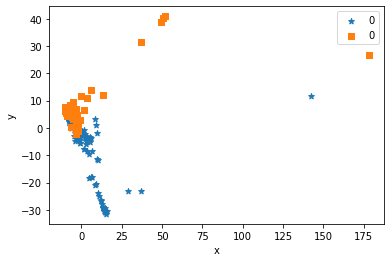

In [691]:
markers = ["*", "s"] 

for i, marker in enumerate(markers):
  x_val = vote_pca[vote_pca["label"] ==i][0] 
  y_val = vote_pca[vote_pca["label"]==i][1] 
  plt.scatter(x_val, y_val, marker=marker,label=new_me.label[i]) 
plt.legend() 
plt.xlabel("x") 
plt.ylabel("y") 
plt.show() # me

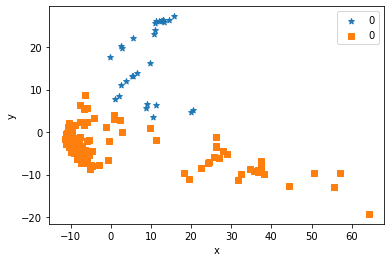

In [700]:
markers = ["*", "s"] 

for i, marker in enumerate(markers):
  x_val = vote_pca[vote_pca["label"] ==i][0] 
  y_val = vote_pca[vote_pca["label"]==i][1] 
  plt.scatter(x_val, y_val, marker=marker,label=new_me.label[i]) 
plt.legend() 
plt.xlabel("x") 
plt.ylabel("y") 
plt.show() #nu

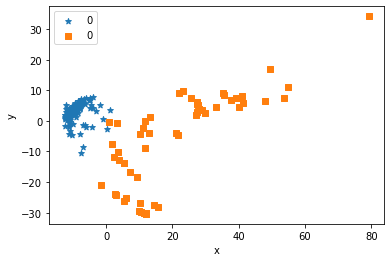

In [704]:
markers = ["*", "s"] 

for i, marker in enumerate(markers):
  x_val = vote_pca[vote_pca["label"] ==i][0] 
  y_val = vote_pca[vote_pca["label"]==i][1] 
  plt.scatter(x_val, y_val, marker=marker,label=new_me.label[i]) 
plt.legend() 
plt.xlabel("x") 
plt.ylabel("y") 
plt.show() #di

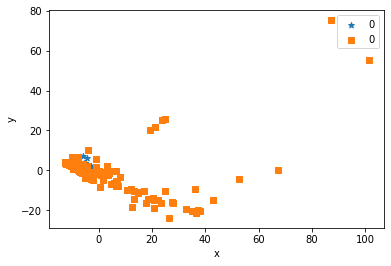

In [708]:
markers = ["*", "s"] 

for i, marker in enumerate(markers):
  x_val = vote_pca[vote_pca["label"] ==i][0] 
  y_val = vote_pca[vote_pca["label"]==i][1] 
  plt.scatter(x_val, y_val, marker=marker,label=new_me.label[i]) 
plt.legend() 
plt.xlabel("x") 
plt.ylabel("y") 
plt.show() #co

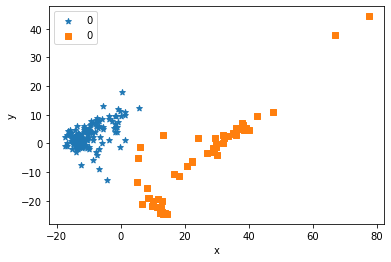

In [712]:
markers = ["*", "s"] 

for i, marker in enumerate(markers):
  x_val = vote_pca[vote_pca["label"] ==i][0] 
  y_val = vote_pca[vote_pca["label"]==i][1] 
  plt.scatter(x_val, y_val, marker=marker,label=new_me.label[i]) 
plt.legend() 
plt.xlabel("x") 
plt.ylabel("y") 
plt.show() #hr

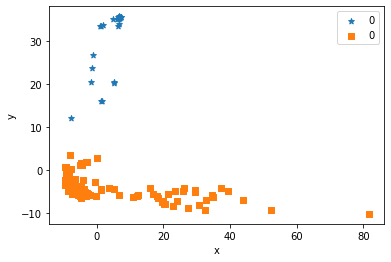

In [716]:
markers = ["*", "s"] 

for i, marker in enumerate(markers):
  x_val = vote_pca[vote_pca["label"] ==i][0] 
  y_val = vote_pca[vote_pca["label"]==i][1] 
  plt.scatter(x_val, y_val, marker=marker,label=new_me.label[i]) 
plt.legend() 
plt.xlabel("x") 
plt.ylabel("y") 
plt.show() #ec

extending

In [13]:
import pandas as pd
path = "E:/votes_550m.csv"
data = pd.read_csv(path)
data.assembly_session.unique()

C:\Users\지완\AppData\Local\Temp\ipykernel_20976\656517041.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., nan])

In [73]:
# data.assembly_session = [range(1, 140)]
import pandas as pd
import numpy as np
# new = pd.DataFrame(index=data.index, columns=data.columns)
columns=data.columns
columns

Index(['Unnamed: 0', 'assembly_session', 'vote_id.x', 'resolution',
       'state_code', 'state_name', 'vote', 'amendment', 'vote_date',
       'yes_votes', 'no_votes', 'abstain', 'colonization', 'human_rights',
       'israel_palestine', 'disarmament', 'nuclear_weapons',
       'economic_development'],
      dtype='object')

In [74]:
r = [np.arange(1, 141)]
new = pd.DataFrame(data)
new.drop(labels=['assembly_session'], axis=1, inplace=True)
assembly_session = [data.assembly_session + 70]

In [75]:
new["assembly_session"] = [n for n in np.array(assembly_session)[0]]

In [76]:
# new = pd.merge(new, data, on='assembly_session', axi)
new = pd.concat([data, new], axis=0, ignore_index=True)

In [78]:
new.shape

(11122734, 18)

In [9]:
first = pd.read_excel("trade_with_usa.xlsx")
second = pd.read_csv("fdi_1994_2017.csv")
first.head()

,country,year,수입_점유율,수출_점유율,수출입_비율
0,캐나다,2016,52.18,72.18,62.18
1,멕시코,2016,46.48,73.68,60.08
2,중국,2016,8.51,21.42,14.96
3,일본,2016,11.41,18.65,15.03
4,독일,2016,6.21,9.39,7.80


In [10]:
data.shape

(5561367, 18)

In [11]:
first.shape

(1475, 5)

In [79]:
# Log-Rank Test 통계적으로 유의미한 차이 / Cox 비례위험 모형
# Kaplan-mieier 생존곡선
# exp(coef): coef 지수값만 비교 (e)니까
# 시각화 
# 히트맵 (straight pattern heat map..)
# random extraction

new.to_csv("./vote_data.csv")